**To be able to run this notebook you need to install the modified PennyLane version that contains the `qml.kernels` module via**
```
pip install git+https://www.github.com/johannesjmeyer/pennylane@kernel_module --upgrade
```

# Quantum Embedding Kernels with PennyLane's kernels module

_Authors: Peter-Jan Derks, Paul Fährmann, Elies Gil-Fuster, Tom Hubregtsen, Johannes Jakob Meyer and David Wierichs_
_On Feb 26th 2021_

Kernel methods are one of the cornerstones of classical machine learning.
To understand what a kernel method does let's first revisit one of the simplest methods to assign binary labels to datapoints: linear classification.

Imagine we want to discern two different classes of points that lie in different corners of the plane.
A linear classifier corresponds to drawing a line and assigning different labels to the regions on opposing sides of the line:

<img src="linear_classification.png" alt="Linear classification." width="300"/>

We can mathematically formalize this by assigning the label $y$ via

$$
y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \boldsymbol{x}\rangle + b).
$$

The vector $\boldsymbol{w}$ points perpendicular to the line and thus determine its slope.
The independent term $b$ specificies the position on the plane.
In this form, linear classification can also be extended to higher dimensional vectors $\boldsymbol{x}$, where a line does not divide the entire space into two regions anymore.
Instead one needs a _hyperplane_.
It is immediately clear that this method is not very powerful, as datasets that are not separable by a hyperplane can't be treated. 

We can actually sneak around this limitation by performing a neat trick: if we define some map $\phi(\boldsymbol{x})$ that _embeds_ our datapoints into a larger _feature space_ and then perform linear classification there, we could actually realise non-linear classification in our original space!

<img src="embedding_nonlinear_classification.png" alt="Linear classification with embedding" width="660"/>

If we go back to the expression for our prediction and include the embedding, we get

$$
y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \phi(\boldsymbol{x})\rangle + b).
$$

We will forgo one tiny step, but it can be shown that for the purposes of optimal classification, we can choose the vector defining the decision boundary as a linear combination of the embedded datapoints $\boldsymbol{w} = \sum_i \alpha_i \phi(\boldsymbol{x}_i)$. Putting this into the formula yields

$$
y(\boldsymbol{x}) = \operatorname{sgn}\left(\sum_i \alpha_i \langle \phi(\boldsymbol{x}_i), \phi(\boldsymbol{x})\rangle + b\right).
$$

This rewriting might not seem useful at first, but notice the above formula only contains inner products between vectors in the embedding space:

$$
k(\boldsymbol{x}, \boldsymbol{y}) = \langle \phi(\boldsymbol{x}), \phi(\boldsymbol{y})\rangle.
$$

We call this function the _kernel_.
The clue now is that we can often find an explicit formula for the kernel $k$ that makes it superfluous to actually perform the embedding $\phi$.
Consider for example the following embedding and the associated kernel:

$$
\phi((x_1, x_2)) = (x_1^2, \sqrt{2} x_1 x_2, x_2^2) \qquad
k(\boldsymbol{x}, \boldsymbol{y}) = x_1^2 y_1^2 + 2 x_1 x_2 y_1 y_2 + x_2^2 y_2^2 = \langle \boldsymbol{x}, \boldsymbol{y} \rangle^2
$$

This means by just replacing the regular scalar product in our linear classification with the map $k$, we can actually express much more intricate decision boundaries!

This is very important, because in many interesting cases the embedding will be much more costlier to compute than the kernel.

In this demonstration, we will explore one particular kind of kernel that can be realized on near-term quantum computers, namely _Quantum Embedding Kernels (QEKs)_.
These are kernels that arise from embedding data into the space of quantum states.
We formalize this by considering a parameterised quantum circuit $U(\boldsymbol{x})$ that embeds datapoint $\boldsymbol{x}$ onto the state

$$
|\psi(\boldsymbol{x})\rangle = U(\boldsymbol{x}) |0 \rangle.
$$

The kernel value is then given by the _overlap_ of the associated embedded quantum states

$$
k(\boldsymbol{x}, \boldsymbol{y}) = | \langle\psi(\boldsymbol{x})|\psi(\boldsymbol{y})\rangle|^2.
$$

## A toy problem

In this demonstration, we will treat a toy problem that showcases the inner workings of our approach. 
We of course need to start with some imports:

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(2658)

And we proceed right away to create the `DoubleCake` dataset.

In [2]:
class DoubleCake:
    def _make_circular_data(self): 
        """Generate datapoints arranged in an even circle."""
        center_indices = np.array(range(0, self.num_sectors))
        sector_angle = 2*np.pi / self.num_sectors
        angles = (center_indices + 0.5) * sector_angle
        x = 0.7 * np.cos(angles)
        y = 0.7 * np.sin(angles)
        labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2)- 1 
        
        return x, y, labels

    def __init__(self, num_sectors):
        self.num_sectors = num_sectors
        
        x1, y1, labels1 = self._make_circular_data()
        x2, y2, labels2 = self._make_circular_data()

        # x and y coordinates of the datapoints
        self.x = np.hstack([x1, .5 * x2])
        self.y = np.hstack([y1, .5 * y2])
        
        # Canonical form of dataset
        self.X = np.vstack([self.x, self.y]).T
        
        self.labels = np.hstack([labels1, -1 * labels2])
        
        # Canonical form of labels
        self.Y = self.labels.astype(int)

    def plot(self, ax, show_sectors=False):
        ax.scatter(self.x, self.y, c=self.labels, cmap=mpl.colors.ListedColormap(['#FF0000', '#0000FF']), s=25, marker='s')
        sector_angle = 360/self.num_sectors
        
        if show_sectors:
            for i in range(self.num_sectors):
                color = ['#FF0000', '#0000FF'][(i % 2)]
                other_color = ['#FF0000', '#0000FF'][((i + 1) % 2)]
                ax.add_artist(mpl.patches.Wedge((0, 0), 1, i * sector_angle, (i+1)*sector_angle, lw=0, color=color, alpha=0.1, width=.5))
                ax.add_artist(mpl.patches.Wedge((0, 0), .5, i * sector_angle, (i+1)*sector_angle, lw=0, color=other_color, alpha=0.1))
                ax.set_xlim(-1, 1)

        ax.set_ylim(-1, 1)
        ax.set_aspect("equal")
        ax.axis("off")

Let's now have a look at our dataset. In our example, we will work with 6 sectors:

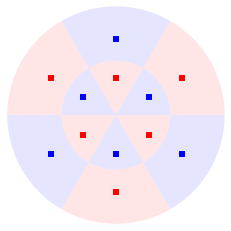

In [3]:
dataset = DoubleCake(6)

dataset.plot(plt.gca(), show_sectors=True)

## Defining a Quantum Embedding Kernel

PennyLane's `kernels` module allows for a particularly simple implementation of Quantum Embedding Kernels.
The first ingredient we need for this is an _Ansatz_ that represents the unitary $U(\boldsymbol{x})$ we use for embedding the data into a quantum state.
We will use a structure where a single layer is repeated multiple times:

In [4]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])
        
    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

@qml.template
def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))
        
def random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))

We are now in a place where we can create the embedding.
Together with the Ansatz we only need a device to run the quantum circuit on.
For the purposes of this tutorial we will use PennyLane's `default.qubit` device with 5 wires.

In [5]:
dev = qml.device("default.qubit", wires=5)
wires = list(range(5))
# compute the kernel matrix
k = qml.kernels.EmbeddingKernel(lambda x, params: ansatz(x, params, wires), dev)

And this was all of the magic!
The `EmbeddingKernel` class took care of providing us with a circuit that calculates the overlap.
Before focusing on the kernel values we have to provide values for the variational parameters.
At this point we fix the number of layers in the Ansatz circuit to $6$.

In [6]:
init_params = random_params(5, 6)

Now we can have a look at the kernel value between the first and the second datapoint:

In [7]:
print("The kernel value between the first and second datapoint is {:.3f}".format(k(dataset.X[0], dataset.X[1], init_params)))

The kernel value between the first and second datapoint is 0.260


The mutual kernel values between all elements of the dataset form the _kernel matrix_.
We can inspect it via the `square_kernel_matrix` method:

In [8]:
K_init = k.square_kernel_matrix(dataset.X, init_params)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.26  0.012 0.021 0.029 0.244 0.705 0.322 0.066 0.033 0.074 0.376]
 [0.26  1.    0.138 0.001 0.01  0.007 0.287 0.639 0.24  0.017 0.008 0.038]
 [0.012 0.138 1.    0.328 0.057 0.003 0.077 0.266 0.657 0.353 0.109 0.058]
 [0.021 0.001 0.328 1.    0.298 0.033 0.052 0.062 0.373 0.728 0.417 0.137]
 [0.029 0.01  0.057 0.298 1.    0.294 0.053 0.027 0.093 0.347 0.63  0.298]
 [0.244 0.007 0.003 0.033 0.294 1.    0.252 0.04  0.027 0.098 0.381 0.654]
 [0.705 0.287 0.077 0.052 0.053 0.252 1.    0.659 0.314 0.239 0.311 0.666]
 [0.322 0.639 0.266 0.062 0.027 0.04  0.659 1.    0.663 0.277 0.156 0.258]
 [0.066 0.24  0.657 0.373 0.093 0.027 0.314 0.663 1.    0.675 0.311 0.216]
 [0.033 0.017 0.353 0.728 0.347 0.098 0.239 0.277 0.675 1.    0.724 0.389]
 [0.074 0.008 0.109 0.417 0.63  0.381 0.311 0.156 0.311 0.724 1.    0.728]
 [0.376 0.038 0.058 0.137 0.298 0.654 0.666 0.258 0.216 0.389 0.728 1.   ]]


## Using the Quantum Embedding Kernel for predictions

The quantum kernel alone can not be used to make predictions on a dataset, becaues it is essentially just a tool to measure the similarity between two datapoints.
To perform an actual prediction we will make use of scikit-learn's Support Vector Classifier (SVC). 

In [9]:
from sklearn.svm import SVC

The `SVC` class expects a function that maps two sets of datapoints to the corresponding kernel matrix.
This is provided by the `kernel_matrix` property of the `EmbeddingKernel` class, so we only need to use a lambda construction to include our parameters.
Once we have this, we can let scikit adjust the SVM from our Quantum Embedding Kernel.

Note this step does not modify the free parameters in our circuit Ansatz.
What it does is solving a different optimization task for the $\alpha$ and $b$ vectors we introduced above.

In [10]:
svm = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, init_params)).fit(dataset.X, dataset.Y)

To see how well our classifier performs we will measure what percentage it classifies correctly.

In [11]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [12]:
print("The accuracy of a kernel with random parameters is {:.3f}".format(accuracy(svm, dataset.X, dataset.Y)))

The accuracy of a kernel with random parameters is 0.583


We are also interested in seeing how the decision boundaries in this classification look like.
This could help us spotting overfitting issues visually in more complex data sets.
To this end we will introduce a second helper method.

In [13]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis,:])

    plot_data = {'_xx' : _xx, '_yy' : _yy, '_zz' : _zz}
    ax.contourf(_xx, _yy, _zz, cmap=mpl.colors.ListedColormap(['#FF0000', '#0000FF']), alpha=.2, levels=[-1, 0,  1])            
    dataset.plot(ax)
    
    return plot_data

With that done, let's have a look at the decision boundaries for our initial classifier:

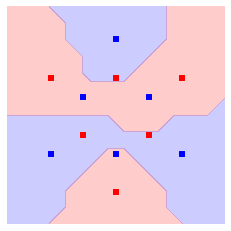

In [14]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

We see the outer points in the dataset can be correctly classified, but we still struggle with the inner circle.
But remember we have a circuit with many free parameters!
It is reasonable to believe we can give values to those parameters which improve the overall accuracy of our SVC.

## Training the Quantum Embedding Kernel

To be able to train the Quantum Embedding Kernel we need some measure of how well it fits the dataset in question.
Performing an exhaustive search in parameter space is not a good solution because it is very resource intensive, and since the accuracy is a discrete quantity we would not be able to detect small improvements. 

We can, however, resort to a more specialized measure, the _kernel-target alignment_ [1].
The kernel-target alignment compares the similarity predicted by the quantum kernel to the actual labels of the training data.
It is based on _kernel alignment_, a similiarity measure between two kernels with given kernel matrices $K_1$ and $K_2$:

$$
\operatorname{KA}(K_1, K_2) = \frac{\operatorname{Tr}(K_1 K_2)}{\sqrt{\operatorname{Tr}(K_1^2)\operatorname{Tr}(K_2^2)}}
$$

Seen from a more theoretical side, this is nothing else than the cosine of the angle between the kernel matrices $K_1$ and $K_2$ seen as vectors in the space of matrices with the Hilbert-Schmidt- (or Frobenius-) scalar product $\langle A, B \rangle = \operatorname{Tr}(A^T B)$.
This reinforces the geometric picture of how this measure relates to objects being aligned in a vector space.

The training data enters the picture by defining a kernel that expresses the labelling in the vector $\boldsymbol{y}$ by assigning the product of the respective labels as the kernel function

$$
k_{\boldsymbol{y}}(\boldsymbol{x}_i, \boldsymbol{x}_j) = y_i y_j
$$

The assigned kernel is thus $+1$ if both datapoints lie in the same class and $-1$ otherwise.
The kernel matrix for this new kernel is simply given by the outer product $\boldsymbol{y}\boldsymbol{y}^T$.
The kernel-target alignment is then defined as the alignment of the kernel matrix generated by the quantum kernel and $\boldsymbol{y}\boldsymbol{y}^T$:

$$
    \operatorname{KTA}_{\boldsymbol{y}}(K) 
    = \frac{\operatorname{Tr}(K \boldsymbol{y}\boldsymbol{y}^T)}{\sqrt{\operatorname{Tr}(K^2)\operatorname{Tr}((\boldsymbol{y}\boldsymbol{y}^T)^2)}} 
    = \frac{\boldsymbol{y}^T K \boldsymbol{y}}{\sqrt{\operatorname{Tr}(K^2)} N}
$$

where $N$ is the number of elements in $\boldsymbol{y}$.

In summary, the kernel-target alignment effectively captures how well the kernel you chose reproduces the actual similarities of the data.
It does have one drawback, however: having a high kernel-target alignment is only a necessary but not a sufficient condition for a good performance of the kernel [1].
This means having good alignment is guaranteed to good performance, but optimal alignment will not always bring optimal training accuracy.

Let's now come back to the actual implementation.
PennyLane's `EmbeddingKernel` class allows you to easily evaluate the kernel target alignment:

In [15]:
print("The kernel-target-alignment for our dataset with random parameters is {:.3f}".format(
    k.target_alignment(dataset.X, dataset.Y, init_params))
)

The kernel-target-alignment for our dataset with random parameters is 0.029


Now let's code up an optimization loop and improve this!

We will make use of regular gradient descent optimization.
To speed up the optimization we will not use the entire training set but rather sample smaller subsets of the data at each step, we choose $4$ datapoints at random.
Remember that PennyLane's inbuilt optimizer works to _minimize_ the cost function that is given to it, which is why we have to multiply the kernel target alignment by $-1$ to actually _maximize_ it in the process. 

In [16]:
params = init_params
opt = qml.GradientDescentOptimizer(2.5)

for i in range(500):
    subset = np.random.choice(list(range(len(dataset.X))), 4)
    params = opt.step(lambda _params: -k.target_alignment(dataset.X[subset], dataset.Y[subset], _params), params)
    
    if (i+1) % 50 == 0:
        print("Step {} - Alignment = {:.3f}".format(i+1, k.target_alignment(dataset.X, dataset.Y, params)))

Step 50 - Alignment = 0.052
Step 100 - Alignment = 0.071
Step 150 - Alignment = 0.091
Step 200 - Alignment = 0.134
Step 250 - Alignment = 0.177
Step 300 - Alignment = 0.218
Step 350 - Alignment = 0.228
Step 400 - Alignment = 0.255
Step 450 - Alignment = 0.308
Step 500 - Alignment = 0.348


We want to assess the impact of training the parameters of the quantum kernel.
Thus, let's build a second support vector classifier with the trained kernel:

In [17]:
svm_trained = SVC(kernel=lambda X1, X2: k.kernel_matrix(X1, X2, params)).fit(dataset.X, dataset.Y)

We expect to see an accuracy improvement vs. the SVM with random parameters:

In [18]:
print("The accuracy of a kernel with trained parameters is {:.3f}".format(accuracy(svm_trained, dataset.X, dataset.Y)))

The accuracy of a kernel with trained parameters is 1.000


Very well!
We now achieved perfect classification!

Following on the results that SVM's have proven good generalisation behavior, it will be interesting to inspect the decision boundaries of our classifier:

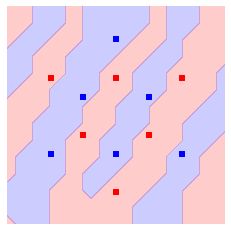

In [19]:
trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())

Indeed, we see that now not only every data instance falls within the correct class, but also that there are no strong artifacts that make us distrust the model.
In this sense, our approach benefits from both:
On the one hand it can adjust itself to the dataset, and on the other hand is not expected to suffer from bad generalisation.

### References

[1] Wang, Tinghua, Dongyan Zhao, and Shengfeng Tian. "An overview of kernel alignment and its applications." _Artificial Intelligence Review_ 43.2 (2015): 179-192.